In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Real-time data preprocessing
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=25.
)

# Convolutional network building
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 3)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0

In [4]:
import json
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [28]:
def train(model, fname, out_fname):
    """ Train and save the provided neural network model on Planesnet dataset

    Args:
        model (tf.keras.models.Sequential): Pre-existing Keras model
        fname (str): Path to PlanesNet JSON dataset
        out_fname (str): Path to output Keras model file (.h5)
    """

    # Load planesnet data
    f = open(fname)
    planesnet = json.load(f)
    f.close()

    # Preprocess image data and labels for input
    X = np.array(planesnet['data']) / 255.
    X = X.reshape([-1, 3, 20, 20]).transpose([0, 2, 3, 1])
    Y = np.array(planesnet['labels'])

    # Convert labels to one-hot encoding
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    Y_categorical = tf.keras.utils.to_categorical(Y_encoded, num_classes=2)

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y_categorical, test_size=0.2, random_state=42)

    # Train the provided model
    history = model.fit(X_train, Y_train, epochs=50, shuffle=True, validation_data=(X_val, Y_val), batch_size=128)
    
    # Save trained model
    model.save(out_fname)

    return X_val, Y_val, label_encoder.classes_, history


In [29]:
X_val, Y_val, classes, history = train(model, "planesnet.json", "model.h5")

Epoch 1/50
200/200 [==============================] - 3s 15ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.1193 - val_accuracy: 0.9839
Epoch 2/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.1236 - val_accuracy: 0.9852
Epoch 3/50
200/200 [==============================] - 3s 14ms/step - loss: 9.2282e-04 - accuracy: 0.9997 - val_loss: 0.1555 - val_accuracy: 0.9839
Epoch 4/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.1112 - val_accuracy: 0.9830
Epoch 5/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1475 - val_accuracy: 0.9830
Epoch 6/50
200/200 [==============================] - 3s 14ms/step - loss: 7.1635e-04 - accuracy: 0.9997 - val_loss: 0.1479 - val_accuracy: 0.9853
Epoch 7/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.1487 - val_accuracy

/Users/ashazahmed/Documents/CS4804/final/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
def evaluate_model(model, X_val, Y_val, class_names):
    """ Evaluate the provided neural network model on validation data and display misclassified images

    Args:
        model (tf.keras.models.Sequential): Trained Keras model
        X_val (numpy.ndarray): Validation image data
        Y_val (numpy.ndarray): True labels for validation data
        class_names (list): List of class names
    """

    # Make predictions on validation data
    Y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(Y_pred, axis=1)
    y_true_labels = np.argmax(Y_val, axis=1)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Display misclassified images
    misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices[:25]):  # Display the first 25 misclassified images
        plt.subplot(5, 5, i + 1)
        plt.imshow(X_val[idx])
        plt.title(f'True: {class_names[y_true_labels[idx]]}, Predicted: {class_names[y_pred_labels[idx]]}')
        plt.axis('off')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

    return accuracy, f1

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Plot the confusion matrix

    Args:
        cm (numpy.ndarray): Confusion matrix
        classes (list): List of class names
        normalize (bool): Whether to normalize the confusion matrix
        title (str): Title of the plot
        cmap (matplotlib.colors.Colormap): Colormap to use
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

200/200 [==============================] - 0s 2ms/step
Accuracy: 0.9845
F1 Score: 0.9846


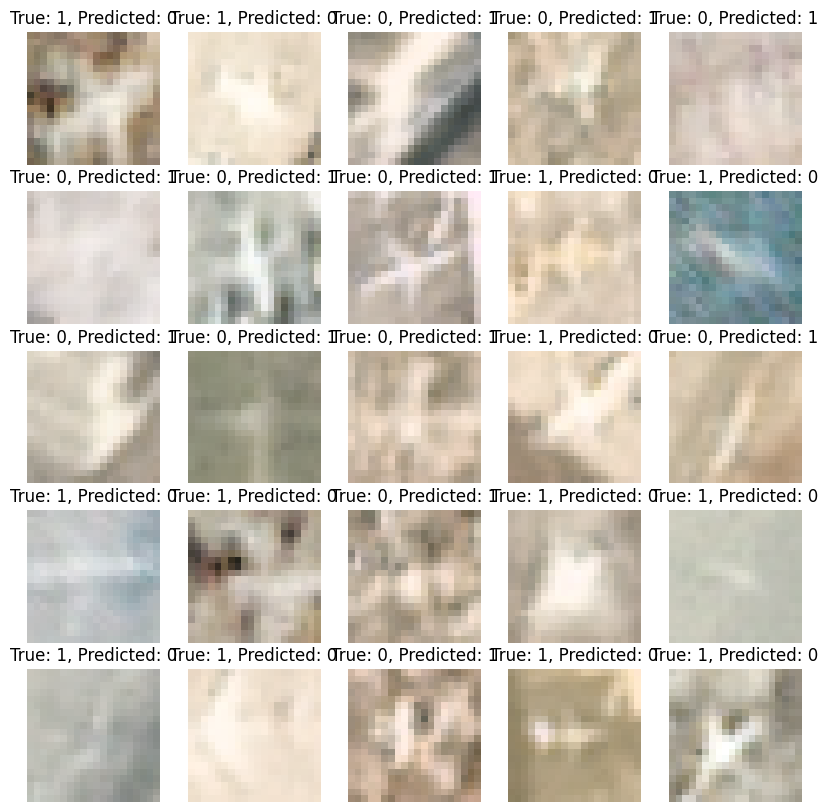

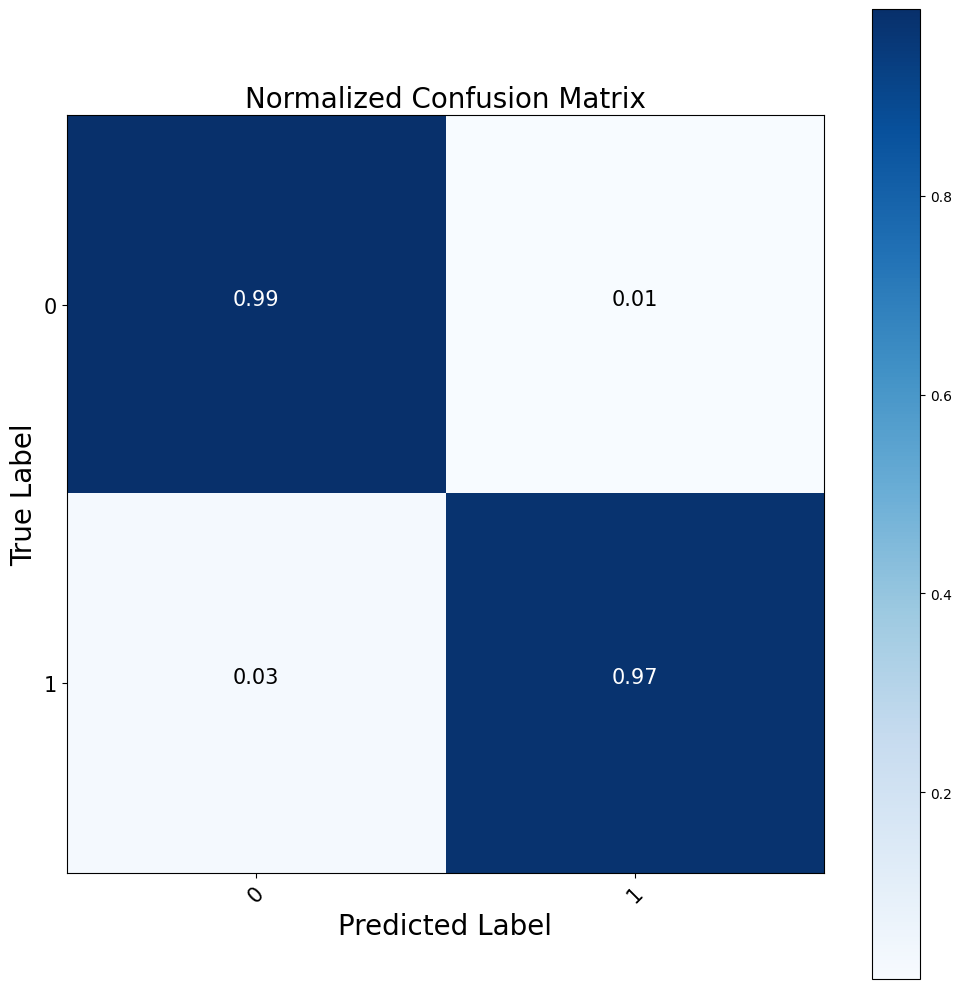

(0.98453125, 0.9845585428982507)

In [35]:
evaluate_model(model, X_val, Y_val, classes)

In [26]:
def plot_history(history):
    """ Plot the training history of a Keras model

    Args:
        history (tf.keras.callbacks.History): History object of a Keras model
    """

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.show()

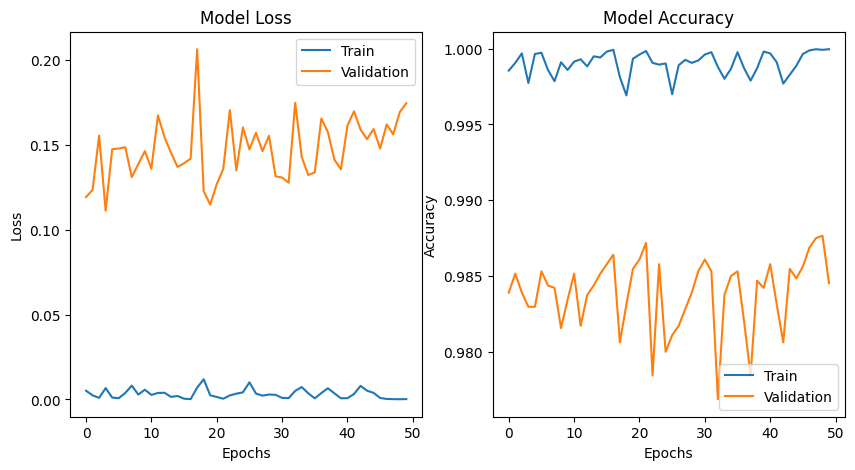

In [36]:
plot_history(history)